In [85]:
import sys
# Add the ptdraft folder path to the sys.path list
sys.path.append('../src/')

from katodata import wormData

# I hate the list comprehensions too. When we start doing serious analysis this wont happen
nname_to_index = [{wormData[i]['NeuronIds'][0][j]:j
                   for j in range(len(wormData[i]['NeuronIds'][0])) 
                   if wormData[i]['NeuronIds'][0][j]!=None}
                  for i in range(5)]

neurons = [ set(filter(lambda x: x!=None, wormData[i]['NeuronIds'][0].values)) for i in range(5) ]
all_shared_neurons = set.intersection(*neurons)

# Let's compute shared neurons in the dataset
from itertools import combinations
groupings  = [ i for i in combinations(range(5), r=2)]
similars = {}
for i,j in groupings: 
    ns_i = neurons[i]
    ns_j = neurons[j] 
    similars[(i,j)] = similars[(j,i)] = set.intersection(set(ns_i), set(ns_j))

for i in range(5):
    groupings.append((i,i))
    similars[(i,i)] = set.intersection(set(neurons[i]), set(neurons[i]))
    
nname_to_index

[{u'AIBL': 67,
  u'AIBR': 55,
  u'ALA': 39,
  u'ASKL': 50,
  u'ASKR': 43,
  u'AVAL': 41,
  u'AVAR': 40,
  u'AVBL': 66,
  u'AVBR': 58,
  u'AVEL': 48,
  u'AVER': 46,
  u'AVFL': 92,
  u'AVFR': 90,
  u'DB01': 102,
  u'DB02': 96,
  u'OLQDL': 20,
  u'OLQDR': 24,
  u'OLQVL': 19,
  u'OLQVR': 21,
  u'RIBL': 69,
  u'RIBR': 63,
  u'RID': 32,
  u'RIFR': 94,
  u'RIGL': 100,
  u'RIML': 73,
  u'RIMR': 70,
  u'RIS': 85,
  u'RIVL': 68,
  u'RIVR': 62,
  u'RMED': 26,
  u'RMEL': 28,
  u'RMER': 27,
  u'RMEV': 44,
  u'SABD': 97,
  u'SIBDR': 49,
  u'SIBVL': 72,
  u'SMBDR': 75,
  u'SMBVL': 76,
  u'SMDVL': 37,
  u'SMDVR': 35,
  u'VA01': 99,
  u'VB01': 93,
  u'VB02': 89,
  u'VD01': 104},
 {u'AIBL': 64,
  u'AIBR': 66,
  u'ALA': 54,
  u'AS01': 119,
  u'ASKL': 56,
  u'ASKR': 48,
  u'AVAL': 46,
  u'AVAR': 39,
  u'AVBL': 74,
  u'AVBR': 71,
  u'AVEL': 52,
  u'AVER': 57,
  u'AVFL': 110,
  u'AVFR': 109,
  u'BAGL': 27,
  u'DA01': 120,
  u'OLQDL': 18,
  u'OLQDR': 23,
  u'OLQVL': 31,
  u'RIBL': 73,
  u'RIBR': 70,
  u'RID'

Now let's build a data structure so we can compare across datasets: we'll use Kato's first assumed neuron names and only later will handle the nuanced case of working with both hypotheses. 

In [ ]:
import numpy as np

def crosscorrelate(a,b):
  return np.dot(a, b.T)

def assemble_shared_dataset(i,j, dataset_name):
    neurons = similars[(i,j)]
    indexes_a = [v for k,v in nname_to_index[i].iteritems() if k in neurons]
    indexes_b = [v for k,v in nname_to_index[j].iteritems() if k in neurons]

    matrix_a = np.take(wormData[i][dataset_name], indexes_a,axis=0)
    matrix_b = np.take(wormData[j][dataset_name], indexes_b,axis=0)
    
    last = min(matrix_a.shape[1], matrix_b.shape[1])
    
    return (matrix_a[:,0:last], matrix_b[:,0:last])

Now we can plot

[(1, 3), (3, 0), (2, 1), (0, 3), (4, 0), (1, 2), (3, 3), (4, 4), (0, 4), (4, 1), (1, 1), (3, 2), (0, 0), (2, 2), (1, 4), (2, 3), (4, 2), (1, 0), (0, 1), (3, 1), (0, 2), (2, 0), (4, 3), (3, 4), (2, 4)]
(30, 3021)


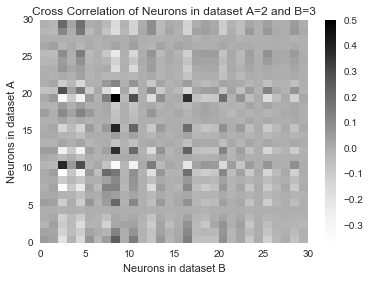

In [86]:
print similars.keys()
a,b = assemble_shared_dataset(2,3, 'deltaFOverF_deriv')

print a.shape

%matplotlib inline
import matplotlib.pyplot as plt
cc = crosscorrelate(a,b)
plt.pcolormesh(cc)   
plt.colorbar()
plt.title('Cross Correlation of Neurons in dataset A=2 and B=3')
plt.ylabel('Neurons in dataset A')
plt.xlabel('Neurons in dataset B')




15


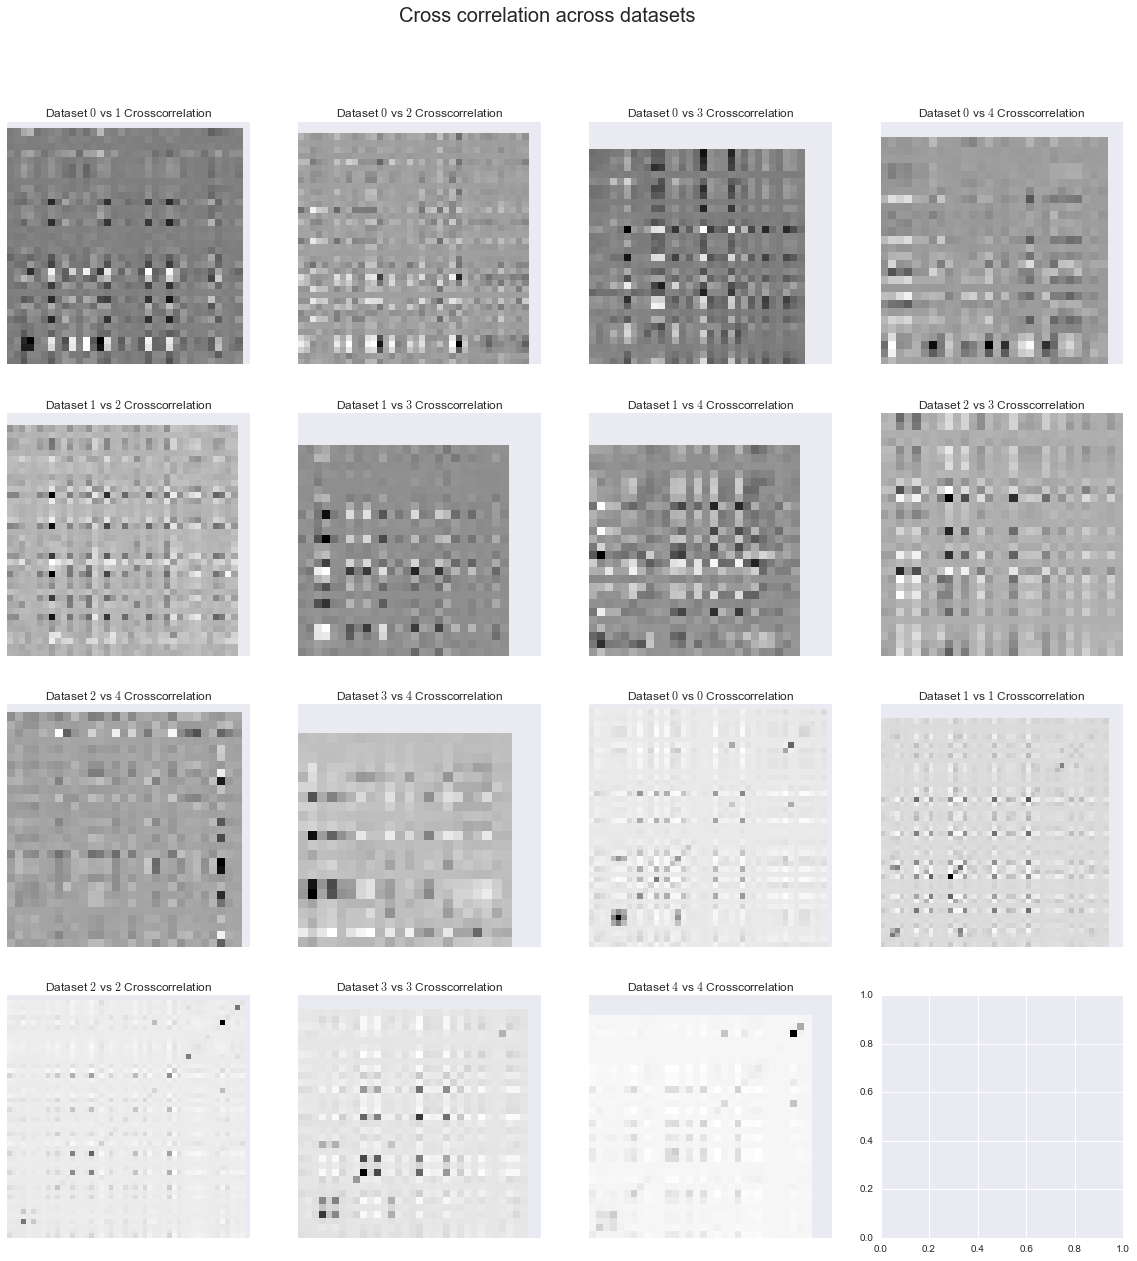

In [107]:
import dimensions_kit as dk

print len(groupings)
f, axes = plt.subplots(4,4,figsize=(20,20))

f.suptitle('Cross correlation across datasets', fontsize=20)
n=0
for k,i in groupings:
    
    x,y = dk.transform((4,4),n)
    
    axis = axes[x][y]
    a,b = assemble_shared_dataset(k,i,'deltaFOverF_deriv')
    axis.pcolormesh(crosscorrelate(a,b))
    
    axis.set_title('Dataset ${0}$ vs ${1}$ Crosscorrelation'.format(k,i))
    plt.setp(axis.get_xticklabels(), visible=False)
    plt.setp(axis.get_yticklabels(), visible=False)

    n+=1
    
while n < dimensions[0]*dimensions[1]:
    x,y = dk.transform(dimensions,n)
    axes[x][y].axis('off')
    n+=1
    
